In [1]:
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate

from keras import backend as K

from keras.datasets import mnist

import tensorflow as tf
import tensorflow_probability as tfp # for tf version 2.0.0, tfp version 0.8 is needed 
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

False

---

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

---

In [4]:
def generate_data(batch_size, max_num_context, testing=False, digit = None, labels = False, img_rows = 28, img_cols = 28):
    max_num_points = img_rows*img_cols
    
    if max_num_context > max_num_points:
        num_context = np.random.randint(3, max_num_points, dtype='int32')
    else:
        num_context = np.random.randint(3, max_num_context, dtype='int32')
    
    # [img_rows, img_cols]
    row_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_rows, dtype='float32'), axis=0), [img_cols,1])
    # [img_cols, img_rows]
    col_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_cols, dtype='float32'), axis=0), [img_rows,1])
    # [img_rows*img_cols, 2]
    x_pairs = np.reshape(np.concatenate((np.expand_dims(np.transpose(row_dim), axis=-1), np.expand_dims(col_dim, axis=-1)), axis=-1), [max_num_points,2])
    
    
    if testing:
        num_target_points = max_num_points
        set_x = x_test
        set_y = y_test
    else:
        num_target_points = np.random.randint(num_context, max_num_points+1, dtype='int32')
        set_x = x_train
        set_y = y_train
    
    context_x = np.zeros([batch_size, num_context, 2])
    context_y = np.zeros([batch_size, num_context, 1])
    
    target_x = np.zeros([batch_size, num_target_points, 2])
    target_y = np.zeros([batch_size, num_target_points, 1])
    
    if labels:
        labels_y = np.zeros([batch_size, 1], dtype='int8')
    
    idx_1 = np.arange(set_x.shape[0])
    np.random.shuffle(idx_1)
        
    for i in range(batch_size):
        
        if digit != None:
            for j in range(set_x.shape[0]):
                if digit == set_y[idx_1[j]]:
                    break
        else:
            j = i
            
        if labels:
            labels_y[i] = set_y[idx_1[j]]
        
        img = np.reshape(set_x[idx_1[j]], [max_num_points,1])/255
        
        idx_2 = np.arange(max_num_points)
        np.random.shuffle(idx_2)
        
        context_x[i] = x_pairs[idx_2[:num_context]]
        context_y[i] = img[idx_2[:num_context]]
        
        if testing:
            target_x[i] = x_pairs
            target_y[i] = img
        else:
            target_x[i] = x_pairs[idx_2[:num_target_points]]
            target_y[i] = img[idx_2[:num_target_points]]


    context_xy = np.concatenate([context_x, context_y], axis=-1)
    
    if labels:
        return [context_xy, target_x], target_y, labels_y    
    
    return [context_xy, target_x], target_y   

In [5]:
def generate(batch_size, max_num_context, testing):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        inputs, targets = generate_data(batch_size, max_num_context, testing=testing)
        yield (inputs, targets)

Digit:  2


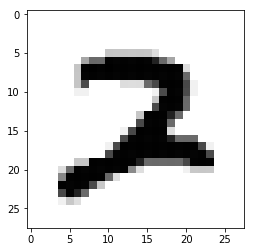

In [6]:
[context_xy, target_x], target_y, labels_y = generate_data(1, 400, testing=True, digit = 2, labels = True, img_rows = 28, img_cols = 28)
plt.imshow(np.array(target_y[0]).reshape([28,28]), cmap='Greys', vmin=0, vmax=1)
print("Digit: ",labels_y[0,0])

___


In [7]:
def log_prob(y_true, y_pred):
    mu, sigma = tf.split(y_pred, 2, axis=-1)

    dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    log_p = dist.log_prob(y_true)
    
    loss = -K.mean(log_p)
    
    return loss

___


In [8]:
"""encoder"""
input_context_xy = Input((None, 3), name="Input_layer_contxt_xy") # [num_pts, 2]
input_target_x = Input((None, 2), name="Input_layer_target_x")  # [num_pts, 1]

encoder = input_context_xy

encoder = Dense(128, activation='relu', name="Encoder_layer_0")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_1")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_2")(encoder)
representation_r_i = Dense(128, activation='linear', name="Encoder_layer_3")(encoder)


"""aggregate"""
representation_r = Lambda(lambda x: K.mean(x, axis=-2), name="Mean_layer_r")(representation_r_i)


"""decoder"""
representation_r_tiled = Lambda(lambda x: K.tile(K.expand_dims(x, axis=-2), [1, K.shape(input_target_x)[-2], 1]), name="Tile_layer_r")(representation_r)

decoder_input = Concatenate(axis=-1, name="Concat_layer_r_target_x")([representation_r_tiled, input_target_x])
decoder = Dense(128, activation='relu', name="Decoder_layer_0")(decoder_input)
decoder = Dense(128, activation='relu', name="Decoder_layer_1")(decoder)
decoder = Dense(128, activation='relu', name="Decoder_layer_2")(decoder)
decoder = Dense(128, activation='relu', name="Decoder_layer_3")(decoder)
decoder = Dense(2, activation='linear', name="Decoder_layer_4")(decoder)

mu, log_sigma = Lambda(lambda x: tf.split(x, 2, axis=-1), name="Split_layer")(decoder)
sigma = Lambda(lambda x: 0.1 + 0.9 * K.softplus(x), name="Softplus_layer_sigma")(log_sigma)


"""build model"""
output = Concatenate(axis=-1, name="Concat_layer_mu_sigma")([mu, sigma])

model = Model([input_context_xy, input_target_x], output)

model.compile(loss=log_prob, optimizer='adam')

model.summary()

# model.load_weights("CNP_mnist_e3_d5_v1.h5")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_contxt_xy (InputLay (None, None, 3)      0                                            
__________________________________________________________________________________________________
Encoder_layer_0 (Dense)         (None, None, 128)    512         Input_layer_contxt_xy[0][0]      
__________________________________________________________________________________________________
Encoder_layer_1 (Dense)         (None, None, 128)    16512       Encoder_layer_0[0][0]            
__________________________________________________________________________________________________
Encoder_layer_2 (Dense)         (None, None, 128)    16512       Encoder_layer_1[0][0]            
____________________________________________________________________________________________

___


In [9]:
def plot_functions(inputs, target_y, labels_y, pred):
    
    target_x = np.array(inputs[1][0]).reshape([img_rows, img_cols, 2])
    target_y = np.array(target_y[0]).reshape([img_rows, img_cols])
    label = labels_y[0,0]
    context_x = np.array(np.round(np.matmul(inputs[0][0, :, 0:2], [[img_rows, 0], [0, img_cols]])), dtype='uint16')
    context_y = np.array(np.round(inputs[0][0, :, 2]*255), dtype='uint8')

    context_img = np.zeros([img_rows, img_cols, 3], dtype='uint8')
    context_img[:,:,2] = 255 # set background blue
    for i in range(context_x.shape[0]):
        context_img[context_x[i,0], context_x[i,1], :] = 255 - context_y[i]

    pred_y = np.array(pred[0, :, 0]).reshape([img_rows, img_cols])
    var = np.array(pred[0, :, 1]).reshape([img_rows, img_cols])    
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2, 2, figsize=(6,6))
    ax1.imshow(target_y, cmap='Greys', vmin=0, vmax=1)
    ax1.set_title("True", fontsize = 12)
    ax2.imshow(pred_y, cmap='Greys', vmin=0, vmax=1)
    ax2.set_title("Predict", fontsize = 12)
    
    ax3.imshow(context_img)
    ax3.set_title("Context Points: Num pts=%i/%i" % (context_x.shape[0], img_rows*img_cols), fontsize = 12)
    
    ax4.imshow(var, cmap='Greys', vmin=0, vmax=1)
    ax4.set_title("Variance", fontsize = 12)
    
    fig.suptitle("Digit: %i" % label, fontsize = 14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    plt.show()

---

In [10]:
MAX_CONTEXT_POINTS = 5e2

repeats = 20
epochs = 50
steps_per_epoch = 2e2
steps_per_validation = 2e2
batch_size = 64

log: r20, e50, spe2e2, spv1e2, b64 &nbsp;&nbsp;&nbsp; CNP_mnist_e3_d5_v1.h5<br>
Total Train: 200000 iterations of batch size 64<br>


Training model
*****************************
Repeat 1
Epoch 1/50
200/200 [==============================] - 26s 130ms/step - loss: -0.0175 - val_loss: -0.5781
Epoch 2/50
200/200 [==============================] - 28s 140ms/step - loss: -0.4363 - val_loss: -0.6859
Epoch 3/50
200/200 [==============================] - 27s 136ms/step - loss: -0.4711 - val_loss: -0.6055
Epoch 4/50
200/200 [==============================] - 25s 127ms/step - loss: -0.4808 - val_loss: -0.6397
Epoch 5/50
200/200 [==============================] - 27s 136ms/step - loss: -0.4960 - val_loss: -0.2156
Epoch 6/50
200/200 [==============================] - 27s 135ms/step - loss: -0.5372 - val_loss: -0.6490
Epoch 7/50
200/200 [==============================] - 28s 138ms/step - loss: -0.5304 - val_loss: -0.4394
Epoch 8/50
200/200 [==============================] - 26s 130ms/step - loss: -0.5494 - val_loss: -0.6896
Epoch 9/50
200/200 [==============================] - 27s 134ms/step - loss: -0.5759 - val_loss: -0.9248
E

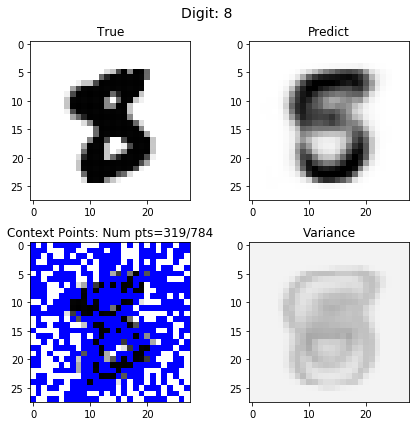

*****************************
Repeat 2
Epoch 1/50
200/200 [==============================] - 27s 135ms/step - loss: -0.8430 - val_loss: -0.9591
Epoch 2/50
200/200 [==============================] - 26s 132ms/step - loss: -0.8391 - val_loss: -0.6052
Epoch 3/50
200/200 [==============================] - 26s 131ms/step - loss: -0.8378 - val_loss: -1.0715
Epoch 4/50
200/200 [==============================] - 26s 129ms/step - loss: -0.8435 - val_loss: -0.9254
Epoch 5/50
200/200 [==============================] - 28s 139ms/step - loss: -0.8593 - val_loss: 0.2687
Epoch 6/50
200/200 [==============================] - 28s 138ms/step - loss: -0.8778 - val_loss: -0.7635
Epoch 7/50
200/200 [==============================] - 27s 136ms/step - loss: -0.8588 - val_loss: -0.5192
Epoch 8/50
200/200 [==============================] - 28s 138ms/step - loss: -0.8647 - val_loss: -0.7723
Epoch 9/50
200/200 [==============================] - 27s 137ms/step - loss: -0.8660 - val_loss: -0.9851
Epoch 10/50
200/2

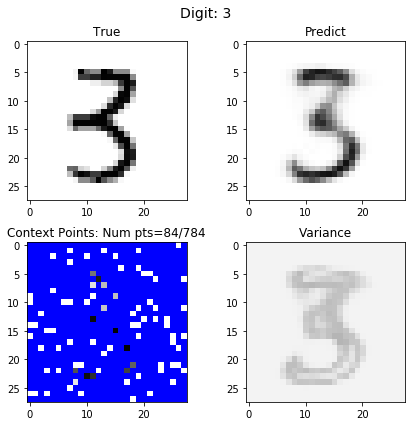

*****************************
Repeat 3
Epoch 1/50
200/200 [==============================] - 27s 137ms/step - loss: -0.9139 - val_loss: -1.1064
Epoch 2/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9245 - val_loss: -0.9392
Epoch 3/50
200/200 [==============================] - 25s 127ms/step - loss: -0.9080 - val_loss: -0.8144
Epoch 4/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9317 - val_loss: -1.0021
Epoch 5/50
200/200 [==============================] - 28s 140ms/step - loss: -0.9421 - val_loss: -1.1106
Epoch 6/50
200/200 [==============================] - 28s 140ms/step - loss: -0.9284 - val_loss: -1.0791
Epoch 7/50
200/200 [==============================] - 26s 129ms/step - loss: -0.9234 - val_loss: -0.6358
Epoch 8/50
200/200 [==============================] - 28s 139ms/step - loss: -0.9185 - val_loss: -0.7652
Epoch 9/50
200/200 [==============================] - 27s 134ms/step - loss: -0.9219 - val_loss: -1.2391
Epoch 10/50
200/

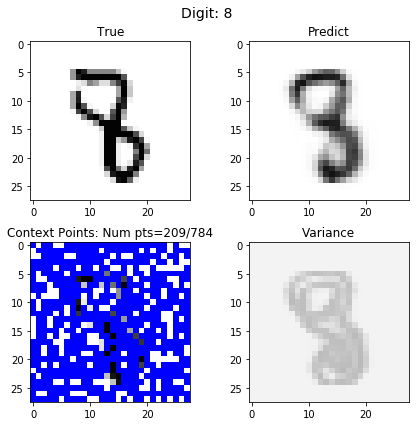

*****************************
Repeat 4
Epoch 1/50
200/200 [==============================] - 27s 135ms/step - loss: -0.9444 - val_loss: -1.2134
Epoch 2/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9496 - val_loss: -0.9939
Epoch 3/50
200/200 [==============================] - 26s 131ms/step - loss: -0.9520 - val_loss: -0.9543
Epoch 4/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9427 - val_loss: -0.0103
Epoch 5/50
200/200 [==============================] - 26s 131ms/step - loss: -0.9391 - val_loss: -1.0281
Epoch 6/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9468 - val_loss: -0.8412
Epoch 7/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9610 - val_loss: -0.9122
Epoch 8/50
200/200 [==============================] - 25s 127ms/step - loss: -0.9269 - val_loss: -1.0263
Epoch 9/50
200/200 [==============================] - 25s 127ms/step - loss: -0.9404 - val_loss: -1.1151
Epoch 10/50
200/

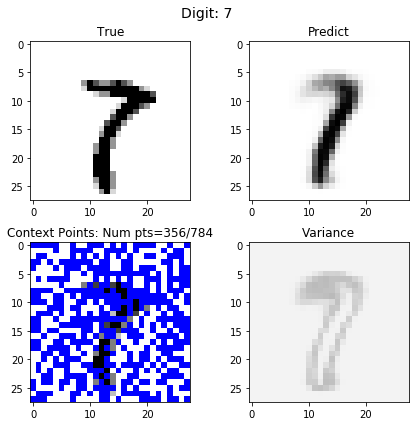

*****************************
Repeat 5
Epoch 1/50
200/200 [==============================] - 26s 131ms/step - loss: -0.9529 - val_loss: -0.8953
Epoch 2/50
200/200 [==============================] - 27s 135ms/step - loss: -0.9723 - val_loss: -1.0360
Epoch 3/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9678 - val_loss: -1.0998
Epoch 4/50
200/200 [==============================] - 27s 137ms/step - loss: -0.9515 - val_loss: -0.8049
Epoch 5/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9845 - val_loss: -0.9684
Epoch 6/50
200/200 [==============================] - 27s 134ms/step - loss: -0.9628 - val_loss: -0.8605
Epoch 7/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9706 - val_loss: -1.1182
Epoch 8/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9661 - val_loss: -0.8829
Epoch 9/50
200/200 [==============================] - 26s 132ms/step - loss: -0.9665 - val_loss: -0.6929
Epoch 10/50
200/

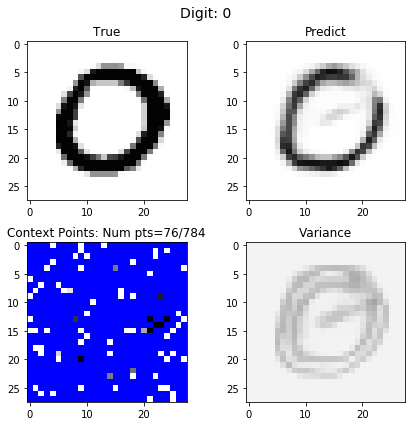

*****************************
Repeat 6
Epoch 1/50
200/200 [==============================] - 26s 132ms/step - loss: -0.9755 - val_loss: -1.0324
Epoch 2/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9635 - val_loss: -0.8993
Epoch 3/50
200/200 [==============================] - 27s 135ms/step - loss: -0.9839 - val_loss: -0.7879
Epoch 4/50
200/200 [==============================] - 26s 129ms/step - loss: -0.9646 - val_loss: -1.0120
Epoch 5/50
200/200 [==============================] - 26s 130ms/step - loss: -0.9789 - val_loss: -1.0988
Epoch 6/50
200/200 [==============================] - 26s 131ms/step - loss: -0.9745 - val_loss: -1.1662
Epoch 7/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9993 - val_loss: -1.0930
Epoch 8/50
200/200 [==============================] - 26s 131ms/step - loss: -0.9870 - val_loss: -0.9425
Epoch 9/50
200/200 [==============================] - 26s 132ms/step - loss: -0.9626 - val_loss: -0.6492
Epoch 10/50
200/

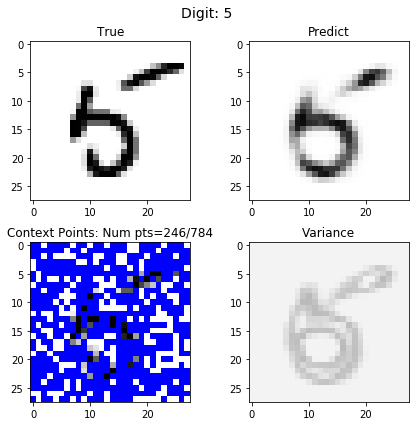

*****************************
Repeat 7
Epoch 1/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0054 - val_loss: -0.9884
Epoch 2/50
200/200 [==============================] - 27s 134ms/step - loss: -0.9892 - val_loss: -1.0539
Epoch 3/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9893 - val_loss: -0.9291
Epoch 4/50
200/200 [==============================] - 27s 135ms/step - loss: -0.9922 - val_loss: -1.0317
Epoch 5/50
200/200 [==============================] - 28s 138ms/step - loss: -0.9759 - val_loss: -1.0675
Epoch 6/50
200/200 [==============================] - 27s 134ms/step - loss: -0.9838 - val_loss: -0.8556
Epoch 7/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9998 - val_loss: -0.9747
Epoch 8/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0013 - val_loss: -1.1053
Epoch 9/50
200/200 [==============================] - 28s 138ms/step - loss: -1.0135 - val_loss: -1.2865
Epoch 10/50
200/

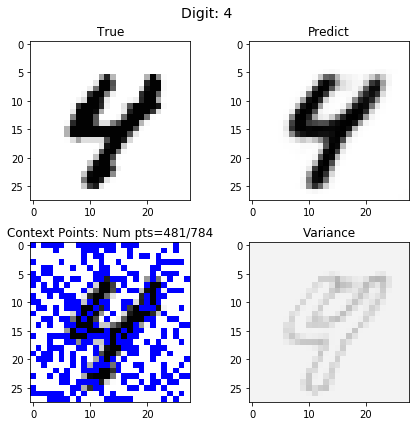

*****************************
Repeat 8
Epoch 1/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0052 - val_loss: -1.2452
Epoch 2/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0022 - val_loss: -1.1532
Epoch 3/50
200/200 [==============================] - 26s 132ms/step - loss: -0.9940 - val_loss: -0.8860
Epoch 4/50
200/200 [==============================] - 28s 138ms/step - loss: -0.9980 - val_loss: -1.0104
Epoch 5/50
200/200 [==============================] - 27s 134ms/step - loss: -0.9973 - val_loss: -1.0116
Epoch 6/50
200/200 [==============================] - 27s 137ms/step - loss: -0.9892 - val_loss: -0.9279
Epoch 7/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9996 - val_loss: -1.0800
Epoch 8/50
200/200 [==============================] - 26s 132ms/step - loss: -0.9910 - val_loss: -0.9319
Epoch 9/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9885 - val_loss: -0.9510
Epoch 10/50
200/

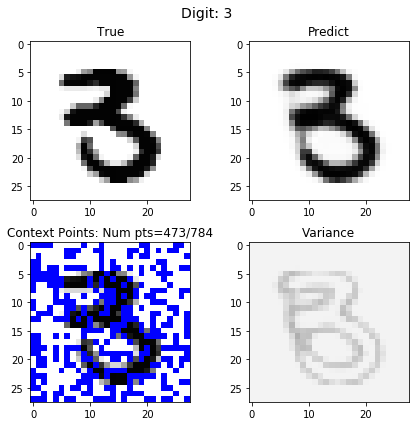

*****************************
Repeat 9
Epoch 1/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9828 - val_loss: -0.6834
Epoch 2/50
200/200 [==============================] - 26s 129ms/step - loss: -0.9992 - val_loss: -1.0990
Epoch 3/50
200/200 [==============================] - 26s 128ms/step - loss: -0.9786 - val_loss: -1.0209
Epoch 4/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9943 - val_loss: -0.6738
Epoch 5/50
200/200 [==============================] - 26s 131ms/step - loss: -0.9864 - val_loss: -1.0947
Epoch 6/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0021 - val_loss: -1.1336
Epoch 7/50
200/200 [==============================] - 27s 135ms/step - loss: -0.9997 - val_loss: -0.9964
Epoch 8/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0046 - val_loss: -0.2232
Epoch 9/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0003 - val_loss: -1.1163
Epoch 10/50
200/

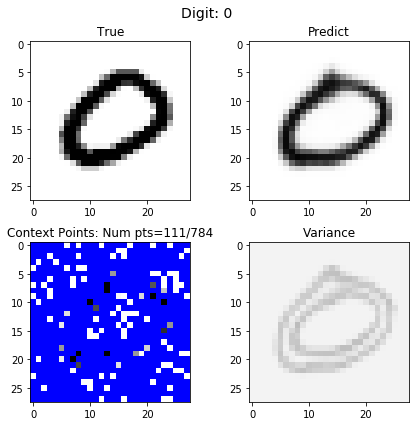

*****************************
Repeat 10
Epoch 1/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0115 - val_loss: -1.0332
Epoch 2/50
200/200 [==============================] - 26s 129ms/step - loss: -0.9892 - val_loss: -0.9273
Epoch 3/50
200/200 [==============================] - 26s 130ms/step - loss: -0.9856 - val_loss: -0.8960
Epoch 4/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0186 - val_loss: -1.1742
Epoch 5/50
200/200 [==============================] - 27s 136ms/step - loss: -0.9835 - val_loss: -1.1294
Epoch 6/50
200/200 [==============================] - 26s 129ms/step - loss: -1.0073 - val_loss: -1.0592
Epoch 7/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0054 - val_loss: -1.0803
Epoch 8/50
200/200 [==============================] - 26s 131ms/step - loss: -0.9957 - val_loss: -1.1169
Epoch 9/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0192 - val_loss: -1.0893
Epoch 10/50
200

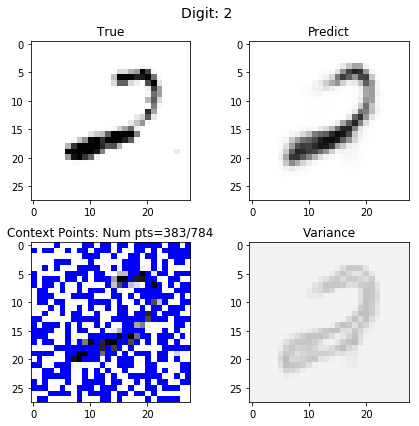

*****************************
Repeat 11
Epoch 1/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0115 - val_loss: -0.3373
Epoch 2/50
200/200 [==============================] - 26s 131ms/step - loss: -1.0089 - val_loss: -0.3601
Epoch 3/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0212 - val_loss: -0.9977
Epoch 4/50
200/200 [==============================] - 27s 134ms/step - loss: -0.9976 - val_loss: -1.0339
Epoch 5/50
200/200 [==============================] - 28s 139ms/step - loss: -1.0113 - val_loss: -1.1173
Epoch 6/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0293 - val_loss: -0.8071
Epoch 7/50
200/200 [==============================] - 28s 138ms/step - loss: -1.0049 - val_loss: -0.6935
Epoch 8/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0087 - val_loss: -0.4046
Epoch 9/50
200/200 [==============================] - 26s 130ms/step - loss: -0.9972 - val_loss: -0.7234
Epoch 10/50
200

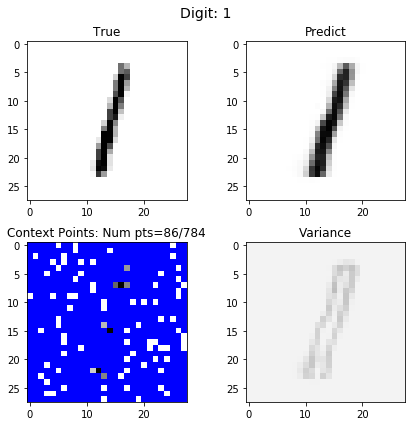

*****************************
Repeat 12
Epoch 1/50
200/200 [==============================] - 29s 144ms/step - loss: -1.0460 - val_loss: -0.7396
Epoch 2/50
200/200 [==============================] - 28s 138ms/step - loss: -1.0199 - val_loss: -1.0814
Epoch 3/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0145 - val_loss: -1.1480
Epoch 4/50
200/200 [==============================] - 27s 133ms/step - loss: -0.9989 - val_loss: -1.1514
Epoch 5/50
200/200 [==============================] - 27s 134ms/step - loss: -1.0211 - val_loss: -0.5915
Epoch 6/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0170 - val_loss: -1.1271
Epoch 7/50
200/200 [==============================] - 27s 134ms/step - loss: -1.0119 - val_loss: -1.0493
Epoch 8/50
200/200 [==============================] - 26s 129ms/step - loss: -0.9987 - val_loss: -0.9116
Epoch 9/50
200/200 [==============================] - 26s 128ms/step - loss: -0.9971 - val_loss: -1.2435
Epoch 10/50
200

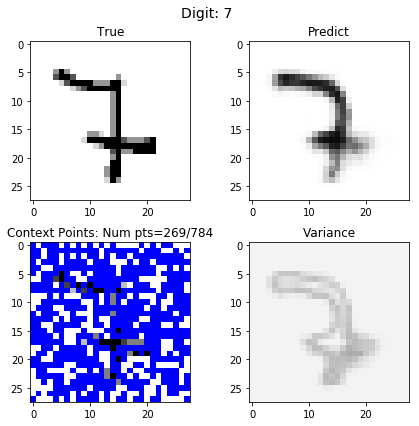

*****************************
Repeat 13
Epoch 1/50
200/200 [==============================] - 28s 142ms/step - loss: -1.0374 - val_loss: -0.7543
Epoch 2/50
200/200 [==============================] - 27s 134ms/step - loss: -0.9995 - val_loss: -0.6812
Epoch 3/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0143 - val_loss: -1.0501
Epoch 4/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0012 - val_loss: -0.9548
Epoch 5/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0270 - val_loss: -1.1624
Epoch 6/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0111 - val_loss: -1.0560
Epoch 7/50
200/200 [==============================] - 28s 140ms/step - loss: -1.0286 - val_loss: -1.0032
Epoch 8/50
200/200 [==============================] - 26s 129ms/step - loss: -0.9967 - val_loss: -1.0873
Epoch 9/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0126 - val_loss: -1.0403
Epoch 10/50
200

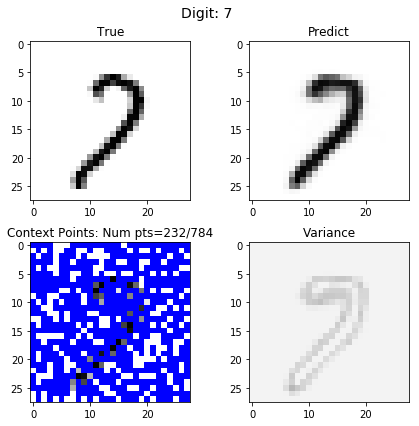

*****************************
Repeat 14
Epoch 1/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0176 - val_loss: -1.0224
Epoch 2/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0179 - val_loss: -1.0146
Epoch 3/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0260 - val_loss: -1.0383
Epoch 4/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0198 - val_loss: -0.8251
Epoch 5/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0222 - val_loss: -1.0175
Epoch 6/50
200/200 [==============================] - 27s 134ms/step - loss: -1.0138 - val_loss: -1.0697
Epoch 7/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0321 - val_loss: -0.8501
Epoch 8/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0026 - val_loss: -1.2157
Epoch 9/50
200/200 [==============================] - 25s 127ms/step - loss: -0.9951 - val_loss: -0.9224
Epoch 10/50
200

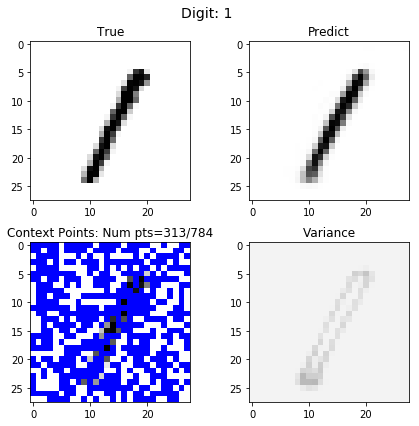

*****************************
Repeat 15
Epoch 1/50
200/200 [==============================] - 27s 134ms/step - loss: -1.0088 - val_loss: -1.0456
Epoch 2/50
200/200 [==============================] - 27s 134ms/step - loss: -1.0223 - val_loss: -0.6200
Epoch 3/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0313 - val_loss: -1.0651
Epoch 4/50
200/200 [==============================] - 28s 139ms/step - loss: -1.0344 - val_loss: -0.7099
Epoch 5/50
200/200 [==============================] - 27s 134ms/step - loss: -1.0120 - val_loss: -0.9972
Epoch 6/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0223 - val_loss: -1.1195
Epoch 7/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0228 - val_loss: -1.0906
Epoch 8/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0351 - val_loss: -0.4891
Epoch 9/50
200/200 [==============================] - 26s 130ms/step - loss: -1.0123 - val_loss: -1.2965
Epoch 10/50
200

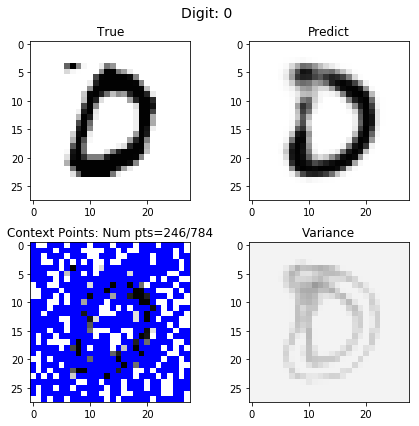

*****************************
Repeat 16
Epoch 1/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0348 - val_loss: -1.0691
Epoch 2/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0298 - val_loss: -1.0731
Epoch 3/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0250 - val_loss: -0.9986
Epoch 4/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0352 - val_loss: -0.3461
Epoch 5/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0210 - val_loss: -0.9751
Epoch 6/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0329 - val_loss: -0.5932
Epoch 7/50
200/200 [==============================] - 26s 131ms/step - loss: -1.0276 - val_loss: -0.8317
Epoch 8/50
200/200 [==============================] - 28s 139ms/step - loss: -1.0403 - val_loss: -0.9210
Epoch 9/50
200/200 [==============================] - 26s 131ms/step - loss: -1.0162 - val_loss: -1.2264
Epoch 10/50
200

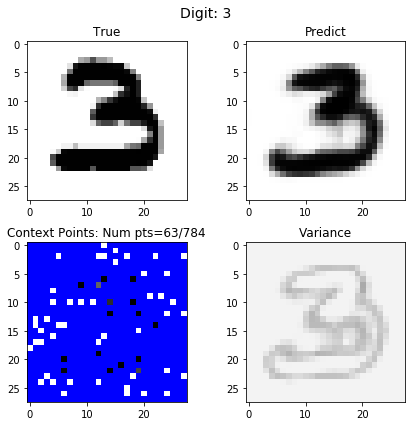

*****************************
Repeat 17
Epoch 1/50
200/200 [==============================] - 26s 131ms/step - loss: -1.0273 - val_loss: -1.0704
Epoch 2/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0223 - val_loss: -1.2519
Epoch 3/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0307 - val_loss: -0.7558
Epoch 4/50
200/200 [==============================] - 26s 129ms/step - loss: -1.0171 - val_loss: -1.1329
Epoch 5/50
200/200 [==============================] - 26s 129ms/step - loss: -1.0269 - val_loss: -1.0946
Epoch 6/50
200/200 [==============================] - 27s 136ms/step - loss: -1.0450 - val_loss: -1.1109
Epoch 7/50
200/200 [==============================] - 27s 134ms/step - loss: -1.0137 - val_loss: -1.1718
Epoch 8/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0200 - val_loss: -0.8428
Epoch 9/50
200/200 [==============================] - 27s 134ms/step - loss: -1.0244 - val_loss: -1.1646
Epoch 10/50
200

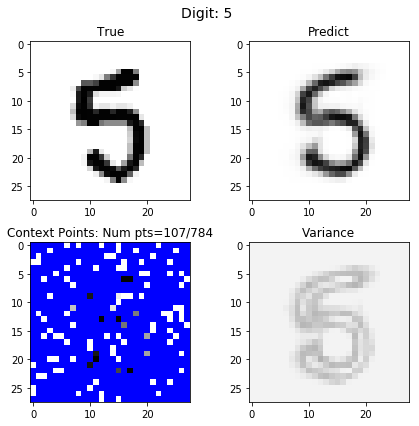

*****************************
Repeat 18
Epoch 1/50
200/200 [==============================] - 28s 139ms/step - loss: -1.0293 - val_loss: -1.2732
Epoch 2/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0365 - val_loss: -0.7459
Epoch 3/50
200/200 [==============================] - 28s 141ms/step - loss: -1.0436 - val_loss: -1.1233
Epoch 4/50
200/200 [==============================] - 26s 131ms/step - loss: -1.0362 - val_loss: -1.1459
Epoch 5/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0290 - val_loss: -1.0804
Epoch 6/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0360 - val_loss: -1.1437
Epoch 7/50
200/200 [==============================] - 25s 125ms/step - loss: -1.0172 - val_loss: -0.5504
Epoch 8/50
200/200 [==============================] - 27s 135ms/step - loss: -1.0305 - val_loss: -0.8536
Epoch 9/50
200/200 [==============================] - 26s 132ms/step - loss: -1.0348 - val_loss: -0.9053
Epoch 10/50
200

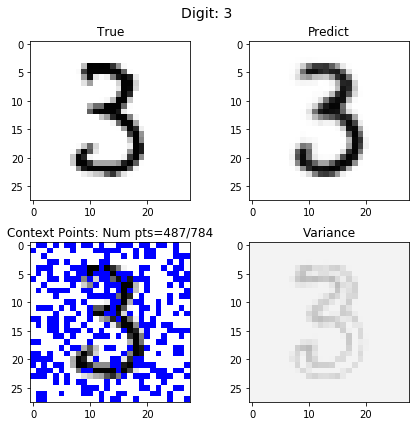

*****************************
Repeat 19
Epoch 1/50
200/200 [==============================] - 26s 128ms/step - loss: -1.0078 - val_loss: -1.0694
Epoch 2/50
200/200 [==============================] - 26s 129ms/step - loss: -1.0219 - val_loss: -0.9992
Epoch 3/50
200/200 [==============================] - 28s 138ms/step - loss: -1.0342 - val_loss: -0.8821
Epoch 4/50
200/200 [==============================] - 28s 141ms/step - loss: -1.0481 - val_loss: -1.0683
Epoch 5/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0284 - val_loss: -1.1925
Epoch 6/50
200/200 [==============================] - 28s 138ms/step - loss: -1.0471 - val_loss: -1.1227
Epoch 7/50
200/200 [==============================] - 28s 142ms/step - loss: -1.0380 - val_loss: -1.2821
Epoch 8/50
200/200 [==============================] - 26s 131ms/step - loss: -1.0093 - val_loss: -0.7476
Epoch 9/50
200/200 [==============================] - 26s 130ms/step - loss: -1.0087 - val_loss: -1.2934
Epoch 10/50
200

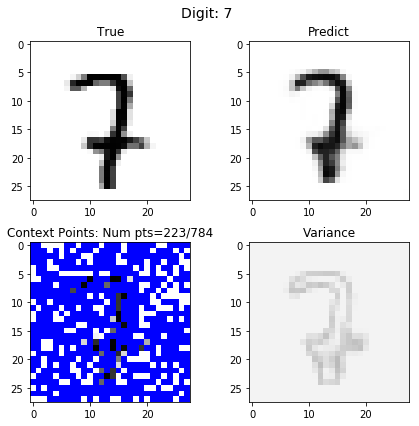

*****************************
Repeat 20
Epoch 1/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0248 - val_loss: -1.2156
Epoch 2/50
200/200 [==============================] - 27s 137ms/step - loss: -1.0273 - val_loss: -1.2663
Epoch 3/50
200/200 [==============================] - 26s 131ms/step - loss: -1.0364 - val_loss: -1.1914
Epoch 4/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0167 - val_loss: -1.1032
Epoch 5/50
200/200 [==============================] - 26s 130ms/step - loss: -1.0124 - val_loss: -1.1396
Epoch 6/50
200/200 [==============================] - 27s 133ms/step - loss: -1.0444 - val_loss: -0.8866
Epoch 7/50
200/200 [==============================] - 28s 141ms/step - loss: -1.0480 - val_loss: -1.1428
Epoch 8/50
200/200 [==============================] - 28s 138ms/step - loss: -1.0600 - val_loss: -1.1161
Epoch 9/50
200/200 [==============================] - 28s 138ms/step - loss: -1.0139 - val_loss: -0.8009
Epoch 10/50
200

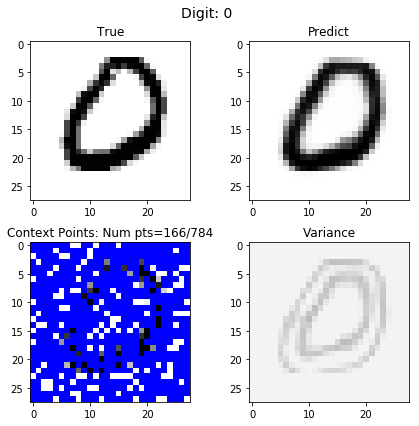

In [11]:
print('Training model')

hist = np.zeros([2, repeats*epochs], dtype='float32')

for i in range(repeats):
    print("*****************************")
    print("Repeat %i" % (i+1))
    history = model.fit_generator(
                    generate(batch_size, MAX_CONTEXT_POINTS, testing=False),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=generate(1, MAX_CONTEXT_POINTS, testing=True),
                    validation_steps=steps_per_validation)
    
    hist[0,i*epochs:(i+1)*epochs] = history.history['loss']
    hist[1,i*epochs:(i+1)*epochs] = history.history['val_loss']
    
    inputs, target_y, labels_y = generate_data(1, MAX_CONTEXT_POINTS, testing=True, labels = True)
    pred = model.predict(inputs, steps=1)

    plot_functions(inputs, target_y, labels_y, pred)
    
# model.save_weights("CNP_mnist_e3_d5_v1.h5")

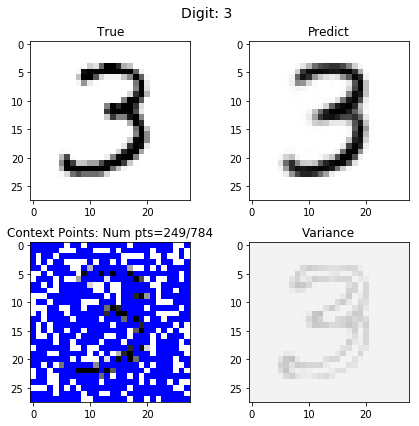

In [12]:
inputs, target_y, labels_y = generate_data(1, 500, testing=True, digit=3, labels = True)
pred = model.predict(inputs, steps=1)

plot_functions(inputs, target_y, labels_y, pred)

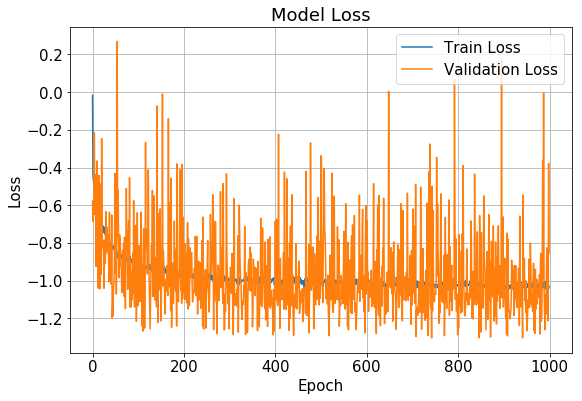

In [13]:
plt.figure(figsize=(9,6))
plt.plot(hist[0])
plt.plot(hist[1])
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.show()

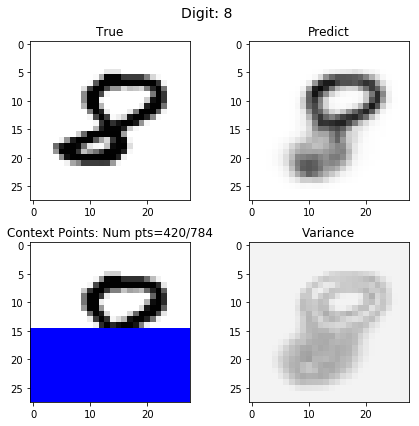

In [17]:
max_num_points = img_rows*img_cols
num_context = 420

# [img_rows, img_cols]
row_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_rows, dtype='float32'), axis=0), [img_cols,1])
# [img_cols, img_rows]
col_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_cols, dtype='float32'), axis=0), [img_rows,1])
# [img_rows*img_cols, 2]
x_pairs = np.reshape(np.concatenate((np.expand_dims(np.transpose(row_dim), axis=-1), np.expand_dims(col_dim, axis=-1)), axis=-1), [max_num_points,2])

context_x = np.zeros([1, num_context, 2])
context_y = np.zeros([1, num_context, 1])

target_x = np.zeros([1, max_num_points, 2])
target_y = np.zeros([1, max_num_points, 1])

labels_y = np.zeros([1, 1], dtype='int8')


labels_y[0] = y_test[61]
img = np.reshape(x_test[61], [max_num_points,1])/255

context_x[0] = x_pairs[:num_context]
context_y[0] = img[:num_context]

target_x[0] = x_pairs
target_y[0] = img

context_xy = np.concatenate([context_x, context_y], axis=-1)  
inputs = [context_xy, target_x]
pred = model.predict(inputs, steps=1)

plot_functions(inputs, target_y, labels_y, pred)